In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

resultsPath = Path("../results/MPI_8.csv")


In [ ]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSize"] = dataFrame["messageSize"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["numIterations"] = dataFrame["numIterations"].astype(int)
dataFrame["totalTime"] = dataFrame["totalTime"].astype(float)
dataFrame["avgRoundTrip"] = dataFrame["avgRoundTrip"].astype(float)
dataFrame["bandwidth"] = dataFrame["bandwidth"].astype(float)

print("Rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Message sizes:", sorted(dataFrame["messageSize"].unique()))
dataFrame.head()

Rows: 105
Modes: ['separate' 'sendrecv' 'isend_irecv']
Message sizes: [1, 16, 1024, 16384, 65536, 262144, 1048576]


,testType,messageSize,numProcesses,mode,numIterations,totalTime,avgRoundTrip,bandwidth,runIndex,mpiEnv
0,MPI_8,1,2,separate,20000,0.006226,3.110000e-07,6424258.088,1,PROCS=2
1,MPI_8,1,2,separate,20000,0.006479,3.240000e-07,6173887.568,2,PROCS=2
2,MPI_8,1,2,separate,20000,0.006275,3.140000e-07,6374197.196,3,PROCS=2
3,MPI_8,1,2,separate,20000,0.005969,2.980000e-07,6701065.413,4,PROCS=2
4,MPI_8,1,2,separate,20000,0.006444,3.220000e-07,6207132.050,5,PROCS=2


In [ ]:
grouped = dataFrame.groupby(["mode","messageSize","numProcesses"], as_index=False).agg(
    medianTotal=("totalTime","median"),
    medianRound=("avgRoundTrip","median"),
    medianBandwidth=("bandwidth","median"),
    stdTotal=("totalTime","std"),
    count=("totalTime","count")
)
grouped["stdTotal"] = grouped["stdTotal"].fillna(0.0)
grouped = grouped.sort_values(["mode","messageSize"]).reset_index(drop=True)
grouped.head(12)

,mode,messageSize,numProcesses,medianTotal,medianRound,medianBandwidth,stdTotal,count
0,isend_irecv,1,2,0.005144,2.570000e-07,7.776352e+06,0.000414,5
1,isend_irecv,16,2,0.005042,2.520000e-07,1.269338e+08,0.000195,5
2,isend_irecv,1024,2,0.001800,3.600000e-07,5.689837e+09,0.000146,5
3,isend_irecv,16384,2,0.004504,2.252000e-06,1.454933e+10,0.000343,5
4,isend_irecv,65536,2,0.008163,4.082000e-06,3.211172e+10,0.000692,5
5,isend_irecv,262144,2,0.006208,1.241600e-05,4.222817e+10,0.000702,5
6,isend_irecv,1048576,2,0.009988,4.994100e-05,4.199259e+10,0.000684,5
7,sendrecv,1,2,0.004193,2.100000e-07,9.540392e+06,0.000139,5
8,sendrecv,16,2,0.003971,1.990000e-07,1.611482e+08,0.000529,5
9,sendrecv,1024,2,0.001422,2.840000e-07,7.200112e+09,0.000077,5


In [6]:
speedupRows = []
for ms, sub in grouped.groupby("messageSize"):
    baseRow = sub[(sub["mode"]=="separate")]
    if baseRow.empty:
        continue
    baseTime = float(baseRow["medianTotal"].values[0])
    for _, row in sub.iterrows():
        speedup = baseTime / row["medianTotal"] if row["medianTotal"] > 0 else np.nan
        speedupRows.append({
            "messageSize": ms,
            "mode": row["mode"],
            "medianTotal": row["medianTotal"],
            "medianRound": row["medianRound"],
            "medianBandwidth": row["medianBandwidth"],
            "speedup": speedup
        })

speedupFrame = pd.DataFrame(speedupRows)
speedupFrame.head()


,messageSize,mode,medianTotal,medianRound,medianBandwidth,speedup
0,1,isend_irecv,0.005144,2.570000e-07,7.776352e+06,1.219868
1,1,sendrecv,0.004193,2.100000e-07,9.540392e+06,1.496542
2,1,separate,0.006275,3.140000e-07,6.374197e+06,1.000000
3,16,isend_irecv,0.005042,2.520000e-07,1.269338e+08,1.211226
4,16,sendrecv,0.003971,1.990000e-07,1.611482e+08,1.537900


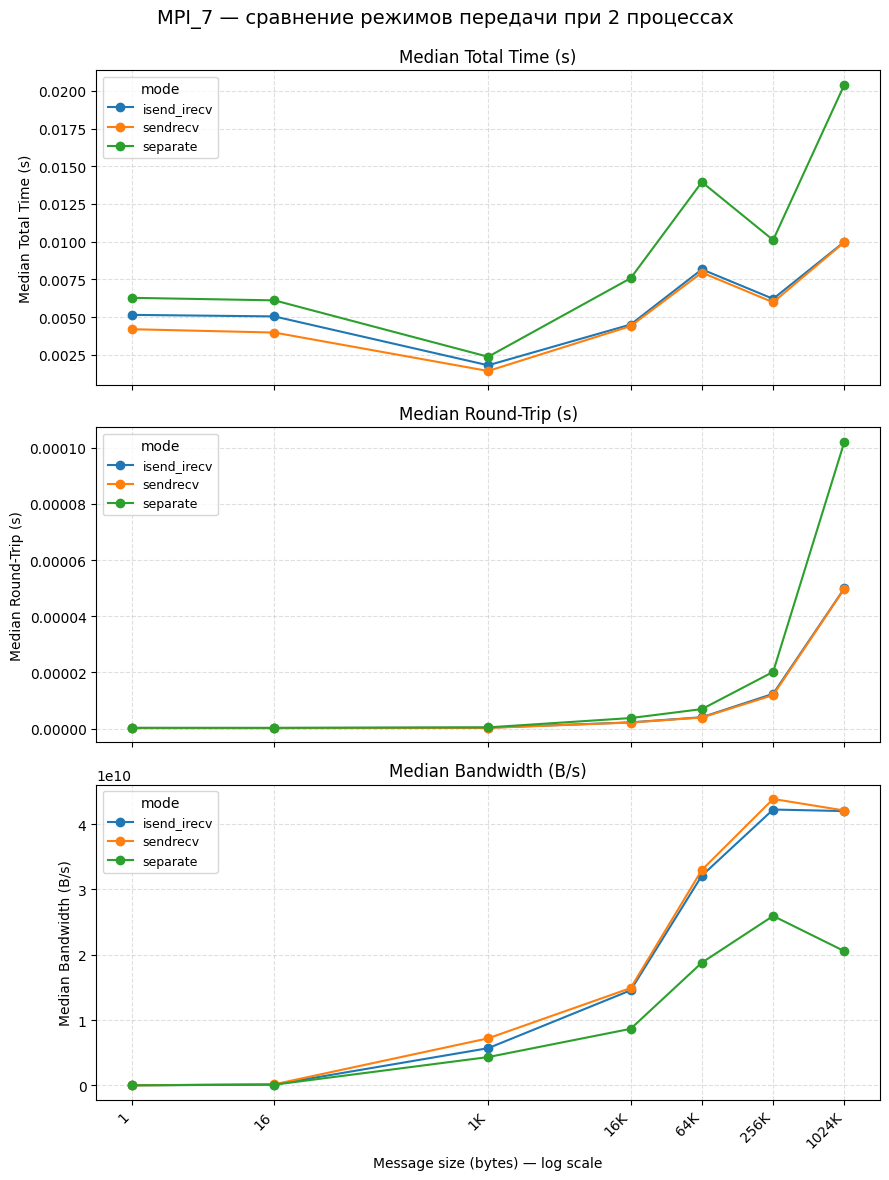

In [ ]:
modes = sorted(grouped["mode"].unique())
metrics = ["medianTotal", "medianRound", "medianBandwidth"]
metricLabels = {"medianTotal":"Median Total Time (s)",
                "medianRound":"Median Round-Trip (s)",
                "medianBandwidth":"Median Bandwidth (B/s)"}

targetNumProcesses = 2
if targetNumProcesses not in grouped["numProcesses"].unique():
    print(f"Warning: there are no results for numProcesses={targetNumProcesses} in 'grouped'. Check your data.")
    
messageSizes = sorted(grouped["messageSize"].unique())

fig, axes = plt.subplots(len(metrics), 1, figsize=(9, 4 * len(metrics)), sharex=True)

if len(metrics) == 1:
    axes = [axes]

for rowIdx, metric in enumerate(metrics):
    ax = axes[rowIdx]
    for modeVal in modes:
        sub = grouped[(grouped["mode"] == modeVal) & (grouped["numProcesses"] == targetNumProcesses)].sort_values("messageSize")
        if sub.empty:
            continue
        x = sub["messageSize"].values
        y = sub[metric].values
        label = f"{modeVal}"
        ax.plot(x, y, marker='o', linestyle='-', label=label)

    ax.set_xscale('log', base=2)
    ax.set_title(metricLabels[metric])
    ax.set_ylabel(metricLabels[metric])
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    ax.legend(title="mode", fontsize=9)

axes[-1].set_xlabel("Message size (bytes) — log scale")
xticks = messageSizes
maxTicks = 10
if len(xticks) > maxTicks:
    indices = np.linspace(0, len(xticks) - 1, maxTicks, dtype=int)
    xticks = [xticks[i] for i in indices]

axes[-1].set_xticks(xticks)
def humanLabel(n):
    if n >= 1024:
        if n % 1024 == 0:
            return f"{n//1024}K"
        else:
            return f"{n/1024:.1f}K"
    return str(n)
axes[-1].set_xticklabels([humanLabel(v) for v in xticks], rotation=45, ha='right')

plt.tight_layout(rect=[0,0,1,0.96])
plt.suptitle("MPI_7 — сравнение режимов передачи при 2 процессах", fontsize=14)
plt.show()


In [8]:
display(speedupFrame.pivot(index="messageSize", columns="mode", values="speedup"))


mode,isend_irecv,sendrecv,separate
messageSize,,,
1,1.219868,1.496542,1.0
16,1.211226,1.537900,1.0
1024,1.313889,1.663150,1.0
16384,1.681838,1.721200,1.0
65536,1.709298,1.755536,1.0
262144,1.628061,1.690416,1.0
1048576,2.043953,2.048259,1.0
